# Mortality walkthrough

This notebook walks through the computation of polynomial mortality (in `global_interaction_Tmean-POLY-4-AgeSpec.csvv`). It is meant to faithfully approximate an actual run, though in some cases corners are cut (e.g. rather than sampling, 1981 weather is used as the no-climate-change counterfactual, and rather than averaging over the baseline period, 2000 impacts are used).

## Setup workspace

In [1]:
import impact
import csvv
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import visualize
#This is our base impact class here
from impact import PolynomialImpact

import impact

In [2]:
# Initialize an impact obj
# In this notebook, this object is only used to compute tstar, the 
# temperature which minimizes mortality in the base period. In full
# simulations, this object would also be used to facilitate impact
# computation.

impact_PI = PolynomialImpact()

## Load weather and covariate data

In [3]:
# weather data setup

weather_path = (
    '/global/scratch/mdelgado/projection/gcp/climate/hierid/popwt/daily/' +
    '{pred}/{read_rcp}/{model}/{year}/{version}.nc4')

prednames = ['tas', 'tas-poly-2', 'tas-poly-3', 'tas-poly-4']


climtas_path = (
    '/global/scratch/jsimcock/data_files/covars/climate/hierid/popwt/{covar}/' +
    '{read_rcp}/{model}/{year}/{version}.nc4')

gdp_path = (
    '/global/scratch/jsimcock/data_files/covars/{covar}/{ssp}/{econmodel}/{year}/{version}.nc')

# covariate setup

def mortality_run_setup(year, rcp, model, ssp, econmodel):

    read_rcp = rcp if year > 2005 else 'historical'
    covar_year = max(2015, year)

    weathers = {pred:
        weather_path.format(
            pred=pred,
            version='1.5',
            read_rcp=read_rcp,
            year=year,
            rcp=rcp,
            model=model,
            ssp=ssp,
            econmodel=econmodel)
        for pred in prednames}
    
    weather = impact.construct_weather(**weathers)
    
    #setup for covars io

    climtas_fp = climtas_path.format(
        covar='tas_kernel_30',
        version='0.1.1',
        read_rcp=rcp,
        year=covar_year,
        rcp=rcp,
        model=model,
        ssp=ssp,
        econmodel=econmodel)

    climtas = xr.open_dataset(climtas_fp).tas.load()

    gdp_fp = gdp_path.format(
        covar='ssp_kernel_13_gdppc',
        version='0.1.3',
        read_rcp=read_rcp,
        year=covar_year,
        rcp=rcp,
        model=model,
        ssp=ssp,
        econmodel=econmodel)

    loggdppc = xr.open_dataset(gdp_fp).loggdppc.load()

    covars_setup  = {
        'loggdppc': loggdppc,
        'climtas': climtas}

    covars = impact.construct_covars(add_constant=True, **covars_setup)

    return weather, covars

## Explore input data

### Test three years for a single model (ACCESS1-0) under rcp 8.5, SSP5, with the high GDP model

In [4]:
metadata = {
    'rcp': 'rcp85',
    'model': 'ACCESS1-0',
    'ssp': 'SSP5',
    'econmodel': 'high'}

w2000, c2000 = mortality_run_setup(year=2000, **metadata)
w2030, c2030 = mortality_run_setup(year=2030, **metadata)
w2080, c2080 = mortality_run_setup(year=2080, **metadata)

### Sample weather data

weather data is indexed by `prednames` (polynomial terms), `time` (days in the year), and `hierid` (impact region)

In [5]:
w2000

<xarray.DataArray 'tas-poly-4' (prednames: 4, time: 365, hierid: 24378)>
array([[[  5.095006e+05,   1.673019e+04, ...,   6.676341e+05,   4.643815e+05],
        [  5.163577e+05,   3.739361e+04, ...,   6.585751e+05,   4.577315e+05],
        ..., 
        [  4.761791e+05,   4.131570e+04, ...,   5.925985e+05,   3.529818e+05],
        [  4.600812e+05,   9.337600e+04, ...,   6.449397e+05,   3.863442e+05]],

       [[  7.136834e+02,   1.243746e+02, ...,   8.168126e+02,   6.793777e+02],
        [  7.184716e+02,   1.865762e+02, ...,   8.112955e+02,   6.745994e+02],
        ..., 
        [  6.899821e+02,   1.982707e+02, ...,   7.693609e+02,   5.898114e+02],
        [  6.782311e+02,   2.989629e+02, ...,   8.022258e+02,   6.169061e+02]],

       [[  1.906814e+04,  -1.429235e+03, ...,   2.335036e+04,   1.774846e+04],
        [  1.926032e+04,  -2.619322e+03, ...,   2.311326e+04,   1.755953e+04],
        ..., 
        [  1.812558e+04,  -2.845871e+03, ...,   2.134924e+04,   1.440269e+04],
        [  1

#### histogram of all observations of tas across impact regions and days by year

/global/home/users/mdelgado/anaconda2/envs/datafs/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


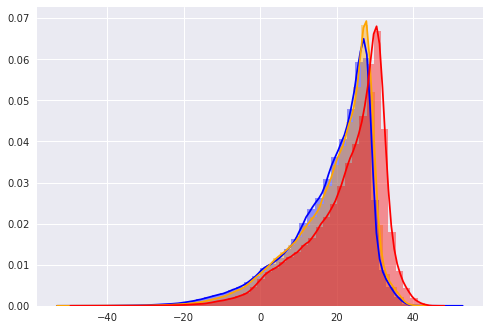

In [7]:
fig, ax = plt.subplots(1, 1)
sns.distplot(w2000.sel(prednames='tas').values.ravel(), color='blue', ax=ax)
sns.distplot(w2030.sel(prednames='tas').values.ravel(), color='orange', ax=ax)
sns.distplot(w2080.sel(prednames='tas').values.ravel(), color='red', ax=ax)

#### Annual average tas

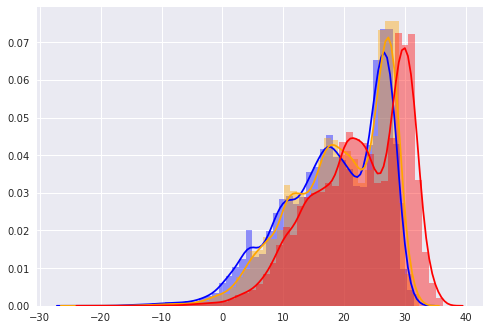

In [42]:
fig, ax = plt.subplots(1, 1)
sns.distplot(w2000.sel(prednames='tas').mean(dim='time').values.ravel(), color='blue', ax=ax)
sns.distplot(w2030.sel(prednames='tas').mean(dim='time').values.ravel(), color='orange', ax=ax)
sns.distplot(w2080.sel(prednames='tas').mean(dim='time').values.ravel(), color='red', ax=ax)

### Sample covariate data

covariate data is indexed by `covarnames` (covariates) and `hierid` (impact region)

In [6]:
c2000

<xarray.DataArray 'loggdppc' (covarnames: 3, hierid: 24378)>
array([[       nan,        nan,        nan, ...,   4.148611,   4.14771 ,
          4.146087],
       [ 26.975577,  -1.353631,   8.724469, ...,  21.536886,  23.90803 ,
         21.86167 ],
       [  1.      ,   1.      ,   1.      , ...,   1.      ,   1.      ,   1.      ]])
Coordinates:
  * hierid      (hierid) object 'ABW' 'AFG.1.12' 'AFG.1.R8abddb145b8788ee' ...
  * covarnames  (covarnames) object 'loggdppc' 'climtas' '1'

#### histogram of all loggdppc values across hierid by year

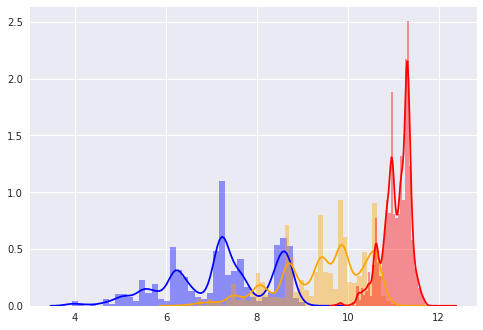

In [8]:
fig, ax = plt.subplots(1, 1)

dropna = lambda x: x[~np.isnan(x)]

sns.distplot(dropna(c2000.sel(covarnames='loggdppc').values.ravel()), color='blue', ax=ax)
sns.distplot(dropna(c2030.sel(covarnames='loggdppc').values.ravel()), color='orange', ax=ax)
sns.distplot(dropna(c2080.sel(covarnames='loggdppc').values.ravel()), color='red', ax=ax)

#### histogram of all climtas values across hierid by year

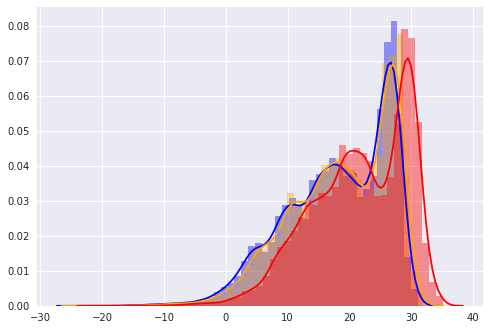

In [9]:
fig, ax = plt.subplots(1, 1)

sns.distplot(c2000.sel(covarnames='climtas').values.ravel(), color='blue', ax=ax)
sns.distplot(c2030.sel(covarnames='climtas').values.ravel(), color='orange', ax=ax)
sns.distplot(c2080.sel(covarnames='climtas').values.ravel(), color='red', ax=ax)

## Building a spaghetti plot

### Construct a synthetic weather dataset

In [10]:
tasvals = np.arange(-20, 50, 0.5)
tas = xr.DataArray(tasvals, dims=('tasvals',), coords={'tasvals': tasvals})
weather_synth = xr.concat(
    [tas**i for i in range(1,5)],
    dim=pd.Index(['tas'] + ['tas-poly-{}'.format(i) for i in range(2,5)], name='prednames'))


In [11]:
weather_synth

<xarray.DataArray (prednames: 4, tasvals: 140)>
array([[ -2.000000e+01,  -1.950000e+01,  -1.900000e+01, ...,   4.850000e+01,
          4.900000e+01,   4.950000e+01],
       [  4.000000e+02,   3.802500e+02,   3.610000e+02, ...,   2.352250e+03,
          2.401000e+03,   2.450250e+03],
       [ -8.000000e+03,  -7.414875e+03,  -6.859000e+03, ...,   1.140841e+05,
          1.176490e+05,   1.212874e+05],
       [  1.600000e+05,   1.445901e+05,   1.303210e+05, ...,   5.533080e+06,
          5.764801e+06,   6.003725e+06]])
Coordinates:
  * tasvals    (tasvals) float64 -20.0 -19.5 -19.0 -18.5 -18.0 -17.5 -17.0 ...
  * prednames  (prednames) object 'tas' 'tas-poly-2' 'tas-poly-3' 'tas-poly-4'

### Get the median response coefficients (gammas)

In [12]:
csvv_file = 'global_interaction_Tmean-POLY-4-AgeSpec.csvv'
gammas = csvv.get_gammas(csvv_file)
gm = gammas.median()

In [13]:
gm

<xarray.DataArray (outcome: 3, prednames: 4, covarnames: 3)>
array([[[ -4.337158e-02,  -2.119506e-03,   7.634971e-03],
        [ -1.156127e-03,  -2.243829e-04,   1.489550e-04],
        [ -4.227101e-04,   1.490188e-05,   3.218977e-05],
        [  1.399401e-05,  -2.273452e-07,  -1.178488e-06]],

       [[  1.408138e-01,   2.914281e-03,  -1.619050e-02],
        [ -6.782383e-03,  -2.052364e-05,   6.804187e-04],
        [ -6.373995e-05,  -4.705649e-06,   9.215832e-06],
        [  5.642453e-06,   9.074323e-08,  -5.820008e-07]],

       [[  6.368397e+00,   5.945595e-02,  -6.973708e-01],
        [ -2.364590e-01,   1.066041e-03,   2.170100e-02],
        [ -6.407747e-03,  -1.300569e-04,   7.485756e-04],
        [  2.770347e-04,   1.774457e-06,  -2.785893e-05]]])
Coordinates:
  * outcome     (outcome) object 'age0-4' 'age5-64' 'age65+'
  * prednames   (prednames) object 'tas' 'tas-poly-2' 'tas-poly-3' 'tas-poly-4'
  * covarnames  (covarnames) object '1' 'climtas' 'loggdppc'

### Compute marginal weather response (beta)

In [14]:
betas2000 = (gm*c2000).sum(dim='covarnames')
betas2030 = (gm*c2030).sum(dim='covarnames')
betas2080 = (gm*c2080).sum(dim='covarnames')

### Compute impact at each point in the synthetic weather data

In [15]:
spaghetti2000 = (betas2000*weather_synth).sum(dim='prednames')
spaghetti2030 = (betas2030*weather_synth).sum(dim='prednames')
spaghetti2080 = (betas2080*weather_synth).sum(dim='prednames')

### Spaghetti plot of impacts

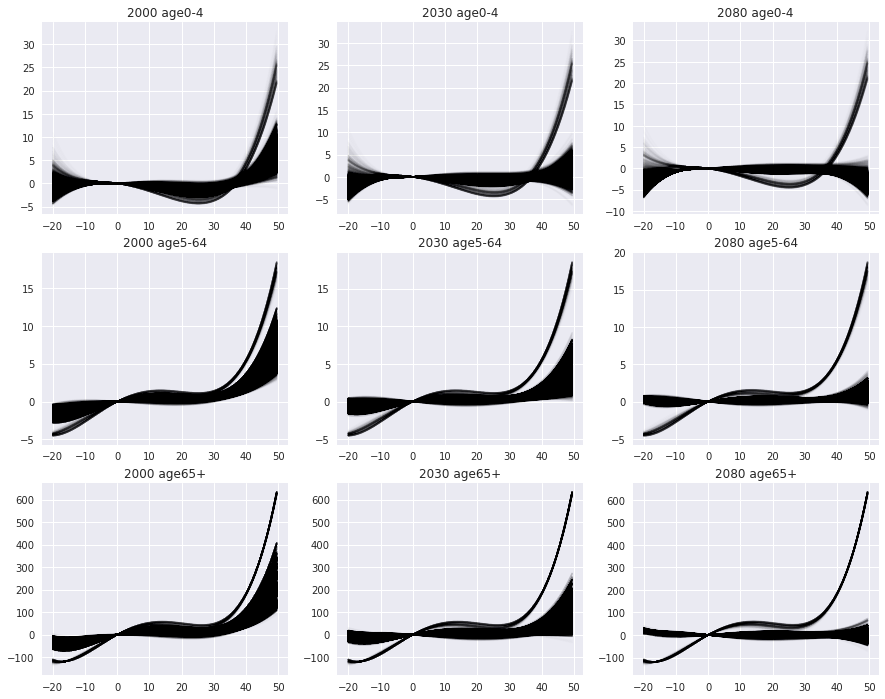

In [16]:
fig, axes = plt.subplots(3, len(spaghetti2000.outcome), figsize=(5*len(spaghetti2000.outcome), 12))

#tqdm notebook is our progress bar
for i, out in enumerate(tqdm_notebook(spaghetti2000.outcome.values)):
    vals = spaghetti2000.sel(outcome=out)
    axes[i, 0].plot(vals.tasvals.values, vals.values.T, color='black', alpha=0.01)
    axes[i, 0].set_title('2000 {}'.format(out))

    vals = spaghetti2030.sel(outcome=out)
    axes[i, 1].plot(vals.tasvals.values, vals.values.T, color='black', alpha=0.01)
    axes[i, 1].set_title('2030 {}'.format(out))
    
    vals = spaghetti2080.sel(outcome=out)
    axes[i, 2].plot(vals.tasvals.values, vals.values.T, color='black', alpha=0.01)
    axes[i, 2].set_title('2080 {}'.format(out))

### Speghetti plot of impacts pinned to zero at t=20

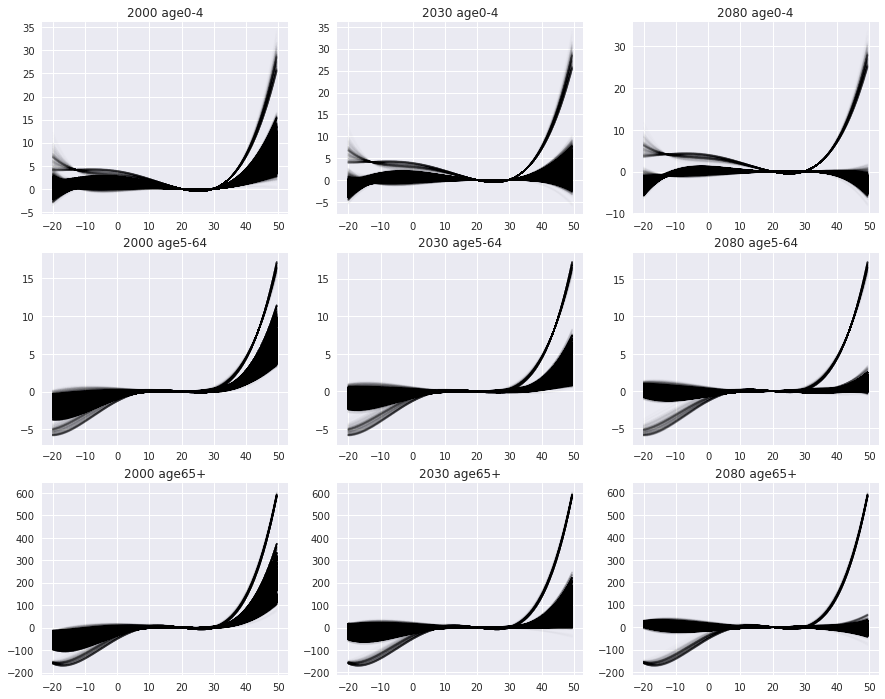

In [17]:
fig, axes = plt.subplots(3, len(spaghetti2000.outcome), figsize=(5*len(spaghetti2000.outcome), 12))

#tqdm notebook is our progress bar
for i, out in enumerate(tqdm_notebook(spaghetti2000.outcome.values)):
    vals = spaghetti2000.sel(outcome=out)
    vals = vals - vals.sel(tasvals=20)
    axes[i, 0].plot(vals.tasvals.values, vals.values.T, color='black', alpha=0.01)
    axes[i, 0].set_title('2000 {}'.format(out))

    vals = spaghetti2030.sel(outcome=out)
    vals = vals - vals.sel(tasvals=20)
    axes[i, 1].plot(vals.tasvals.values, vals.values.T, color='black', alpha=0.01)
    axes[i, 1].set_title('2030 {}'.format(out))
    
    vals = spaghetti2080.sel(outcome=out)
    vals = vals - vals.sel(tasvals=20)
    axes[i, 2].plot(vals.tasvals.values, vals.values.T, color='black', alpha=0.01)
    axes[i, 2].set_title('2080 {}'.format(out))

### Impacts computed with real weather

In [18]:
impacts2000 = (betas2000*w2000).sum(dim='prednames')
impacts2030 = (betas2030*w2030).sum(dim='prednames')
impacts2080 = (betas2080*w2080).sum(dim='prednames')

In [19]:
impacts2000

<xarray.DataArray (outcome: 3, hierid: 24378, time: 365)>
array([[[  -4.220765,   -4.214358, ...,   -4.247371,   -4.257073],
        [   1.213257,    2.08378 , ...,    2.248732,    4.105031],
        ..., 
        [  -2.587192,   -2.597774, ...,   -2.664093,   -2.609021],
        [  -2.640591,   -2.643726, ...,   -2.631486,   -2.636063]],

       [[   1.112323,    1.115662, ...,    1.098248,    1.09291 ],
        [  -2.176364,   -2.755326, ...,   -2.862165,   -3.555006],
        ..., 
        [   0.841724,    0.836299, ...,    0.80308 ,    0.830905],
        [   0.724441,    0.722633, ...,    0.720525,    0.721205]],

       [[  41.192008,   41.233002, ...,   41.071244,   41.066061],
        [ -85.486533, -102.865883, ..., -106.030138, -120.802   ],
        ..., 
        [  27.558023,   27.426874, ...,   26.695175,   27.328056],
        [  24.647616,   24.631874, ...,   25.318389,   25.10113 ]]])
Coordinates:
  * outcome  (outcome) object 'age0-4' 'age5-64' 'age65+'
  * hierid   (hieri

In [20]:
impacts2000.min(), impacts2000.max()

(<xarray.DataArray ()>
 array(-205.45020031611693), <xarray.DataArray ()>
 array(504.88057936005623))

In [21]:
impacts2080.min(), impacts2080.max()

(<xarray.DataArray ()>
 array(-591.3046661372), <xarray.DataArray ()>
 array(306.1560764470555))

### Maps of median run impacts (raw impact - no flat curve clipping, no removal of baseline)

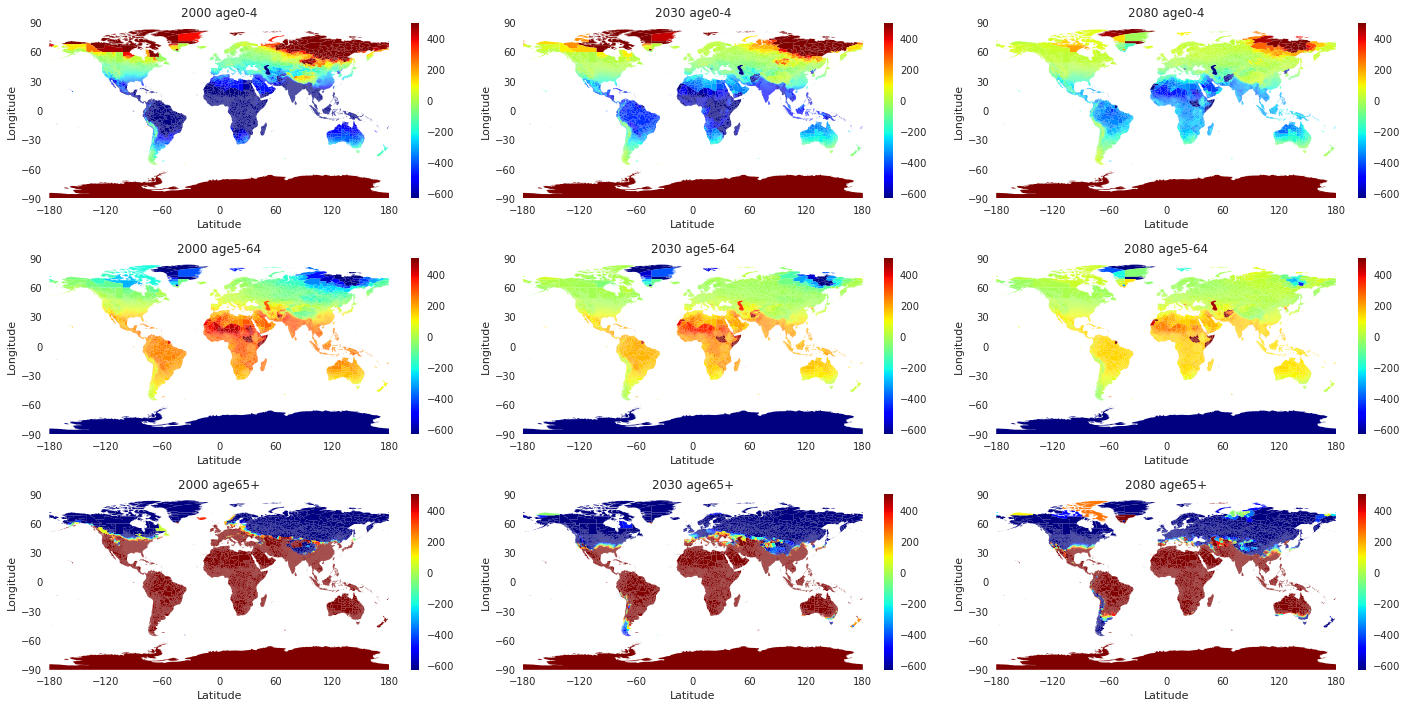

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

yrange = [
    min(impacts2000.min(), impacts2030.min(), impacts2080.min()),
    max(impacts2000.max(), impacts2030.max(), impacts2080.max())]

formatting = dict(clim=yrange, edgecolors='none', facecolor='white', linewidth=0)

for i, out in enumerate(impacts2000.outcome.values):
    visualize.plot_by_hierid(impacts2000.sum(dim='time').sel(outcome=out), ax=axes[i, 0], **formatting)
    axes[i, 0].set_title('2000 {}'.format(out))
    axes[i, 0].set_facecolor('white')
    
    visualize.plot_by_hierid(impacts2030.sum(dim='time').sel(outcome=out), ax=axes[i, 1], **formatting)
    axes[i, 1].set_title('2030 {}'.format(out))
    axes[i, 1].set_facecolor('white')
    
    visualize.plot_by_hierid(impacts2080.sum(dim='time').sel(outcome=out), ax=axes[i, 2], **formatting)
    axes[i, 2].set_title('2080 {}'.format(out))
    axes[i, 2].set_facecolor('white')

plt.tight_layout()

### With flat-curve clipping

In [23]:
tstar = impact_PI.compute_t_star(betas2000, [10, 25])

In [24]:
tstar

<xarray.DataArray (outcome: 3, prednames: 4, hierid: 24378)>
array([[[  1.838439e+01,   2.156587e+01, ...,   1.784915e+01,   1.820462e+01],
        [  3.379857e+02,   4.650866e+02, ...,   3.185922e+02,   3.314082e+02],
        [  6.213659e+03,   1.003000e+04, ...,   5.686600e+03,   6.033161e+03],
        [  1.142343e+05,   2.163056e+05, ...,   1.015010e+05,   1.098314e+05]],

       [[  2.500000e+01,   2.395653e+01, ...,   2.500000e+01,   2.500000e+01],
        [  6.250000e+02,   5.739154e+02, ...,   6.250000e+02,   6.250000e+02],
        [  1.562500e+04,   1.374902e+04, ...,   1.562500e+04,   1.562500e+04],
        [  3.906250e+05,   3.293789e+05, ...,   3.906250e+05,   3.906250e+05]],

       [[  2.500000e+01,   2.500000e+01, ...,   2.500000e+01,   2.500000e+01],
        [  6.250000e+02,   6.250000e+02, ...,   6.250000e+02,   6.250000e+02],
        [  1.562500e+04,   1.562500e+04, ...,   1.562500e+04,   1.562500e+04],
        [  3.906250e+05,   3.906250e+05, ...,   3.906250e+05,   3.

In [25]:
mstar2000 = (betas2000*tstar).sum(dim='prednames')
mstar2030 = (betas2030*tstar).sum(dim='prednames')
mstar2080 = (betas2080*tstar).sum(dim='prednames')

In [26]:
mstar2000

<xarray.DataArray (outcome: 3, hierid: 24378)>
array([[ -3.515764,  -2.618465,  -2.972669, ...,  -2.176635,  -2.239966,
         -2.186129],
       [  1.081632,   0.431597,   0.68101 , ...,   0.70152 ,   0.753625,
          0.708808],
       [ 41.468243,  18.417248,  26.617626, ...,  24.360361,  26.292476,
         24.63235 ]])
Coordinates:
  * outcome  (outcome) object 'age0-4' 'age5-64' 'age65+'
  * hierid   (hierid) object 'ABW' 'AFG.1.12' 'AFG.1.R8abddb145b8788ee' ...

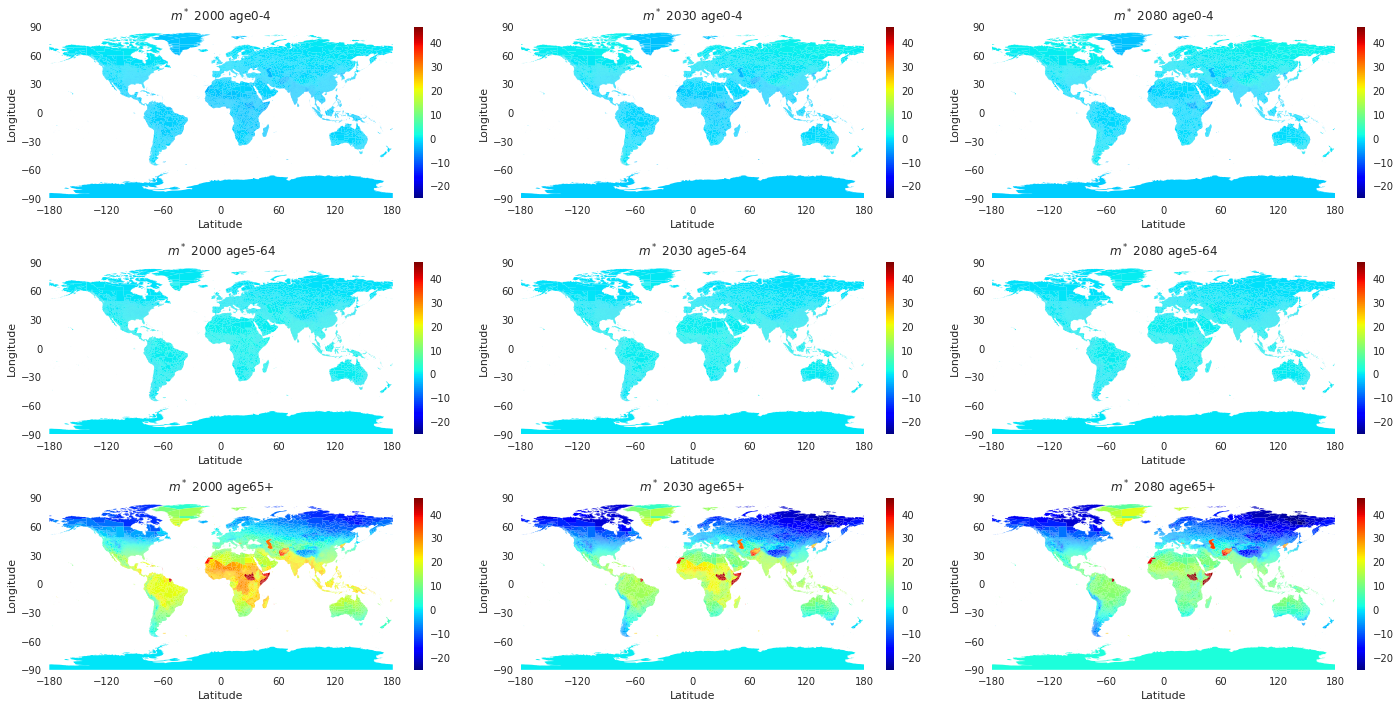

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

yrange = [
    min(mstar2000.min(), mstar2030.min(), mstar2080.min()),
    max(mstar2000.max(), mstar2030.max(), mstar2080.max())]

formatting = dict(clim=yrange, edgecolors='none', facecolor='white', linewidth=0)

for i, out in enumerate(mstar2000.outcome.values):
    visualize.plot_by_hierid(mstar2000.sel(outcome=out), ax=axes[i, 0], **formatting)
    axes[i, 0].set_title('$m^*$ 2000 {}'.format(out))
    axes[i, 0].set_facecolor('white')
    
    visualize.plot_by_hierid(mstar2030.sel(outcome=out), ax=axes[i, 1], **formatting)
    axes[i, 1].set_title('$m^*$ 2030 {}'.format(out))
    axes[i, 1].set_facecolor('white')
    
    visualize.plot_by_hierid(mstar2080.sel(outcome=out), ax=axes[i, 2], **formatting)
    axes[i, 2].set_title('$m^*$ 2080 {}'.format(out))
    axes[i, 2].set_facecolor('white')

plt.tight_layout()

In [28]:
# do the clip
clipped2000 = xr.ufuncs.maximum(impacts2000, mstar2000)
clipped2030 = xr.ufuncs.maximum(impacts2030, mstar2030)
clipped2080 = xr.ufuncs.maximum(impacts2080, mstar2080)

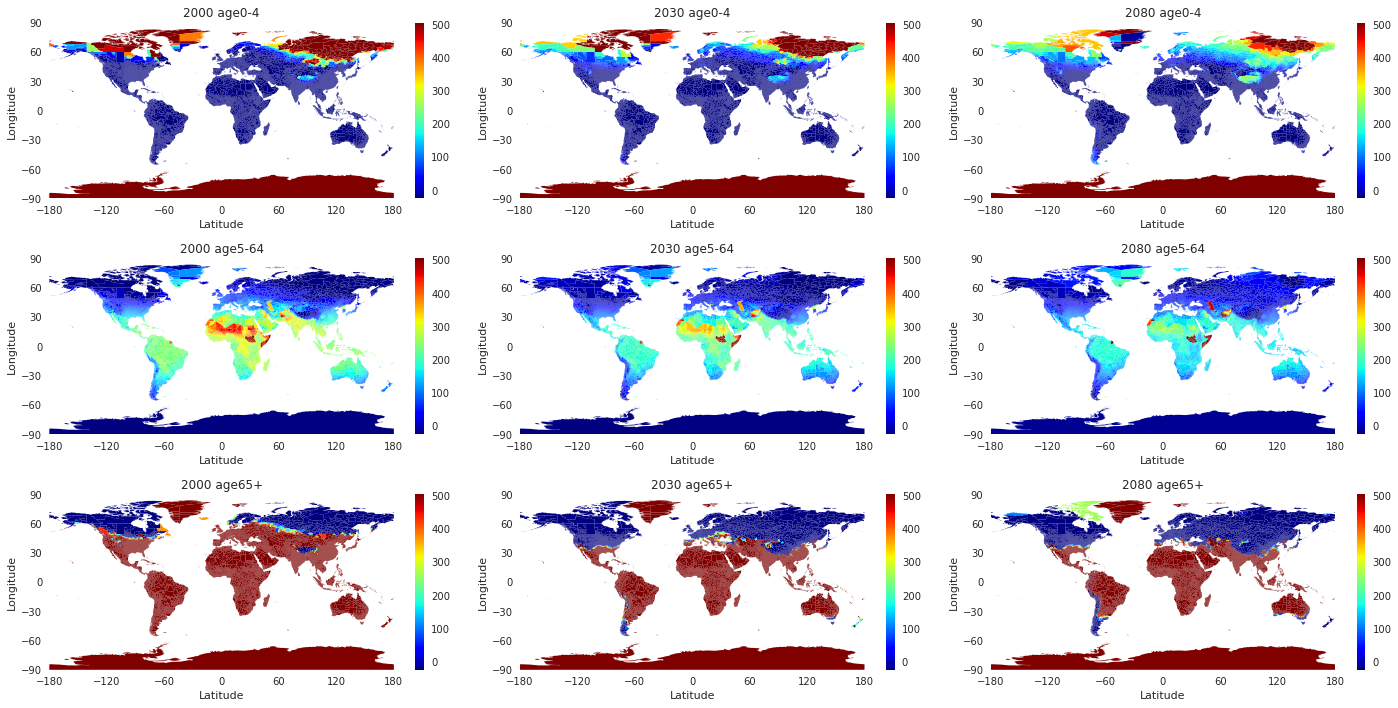

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

yrange = [
    min(clipped2000.min(), clipped2030.min(), clipped2080.min()),
    max(clipped2000.max(), clipped2030.max(), clipped2080.max())]

formatting = dict(clim=yrange, edgecolors='none', facecolor='white', linewidth=0)

for i, out in enumerate(clipped2000.outcome.values):
    visualize.plot_by_hierid(clipped2000.sum(dim='time').sel(outcome=out), ax=axes[i, 0], **formatting)
    axes[i, 0].set_title('2000 {}'.format(out))
    axes[i, 0].set_facecolor('white')
    
    visualize.plot_by_hierid(clipped2030.sum(dim='time').sel(outcome=out), ax=axes[i, 1], **formatting)
    axes[i, 1].set_title('2030 {}'.format(out))
    axes[i, 1].set_facecolor('white')
    
    visualize.plot_by_hierid(clipped2080.sum(dim='time').sel(outcome=out), ax=axes[i, 2], **formatting)
    axes[i, 2].set_title('2080 {}'.format(out))
    axes[i, 2].set_facecolor('white')

plt.tight_layout()

### Subtract baseline value

In [30]:
clipped2030

<xarray.DataArray (outcome: 3, hierid: 24378, time: 365)>
array([[[ -3.540071,  -3.540071, ...,  -3.540071,  -3.540071],
        [  1.268498,   1.600538, ...,   1.072763,   2.559099],
        ..., 
        [ -1.692856,  -1.692856, ...,  -1.692856,  -1.692856],
        [ -1.623902,  -1.623902, ...,  -1.623902,  -1.623902]],

       [[  1.146096,   1.151056, ...,   1.197662,   1.183484],
        [  0.449083,   0.449083, ...,   0.449083,   0.449083],
        ..., 
        [  0.670436,   0.748167, ...,   0.63647 ,   0.638967],
        [  0.584975,   0.602712, ...,   0.593154,   0.588075]],

       [[ 41.935154,  42.02269 , ...,  42.996244,  42.68304 ],
        [ 19.029784,  19.029784, ...,  19.029784,  19.029784],
        ..., 
        [ 20.385563,  22.37305 , ...,  19.704491,  19.704491],
        [ 18.178805,  18.295837, ...,  18.834708,  18.555364]]])
Coordinates:
  * outcome  (outcome) object 'age0-4' 'age5-64' 'age65+'
  * hierid   (hierid) object 'ABW' 'AFG.1.12' 'AFG.1.R8abddb145b878

### Subtract off 2000 value (proxy for historical baseline)

In [31]:
rebased2030 = clipped2030.sum(dim='time') - clipped2000.sum(dim='time')
rebased2080 = clipped2080.sum(dim='time') - clipped2000.sum(dim='time')

In [32]:
rebased2030

<xarray.DataArray (outcome: 3, hierid: 24378)>
array([[   -8.872114,  -209.70015 ,   -81.914356, ...,   190.787015,
          196.625124,   190.264076],
       [    7.796167,     7.110988,    11.896853, ...,   -60.601951,
          -47.931941,   -57.848669],
       [  210.715179,   280.964111,   486.16648 , ..., -3217.123565,
        -2682.375536, -3120.437762]])
Coordinates:
  * outcome  (outcome) object 'age0-4' 'age5-64' 'age65+'
  * hierid   (hierid) object 'ABW' 'AFG.1.12' 'AFG.1.R8abddb145b8788ee' ...

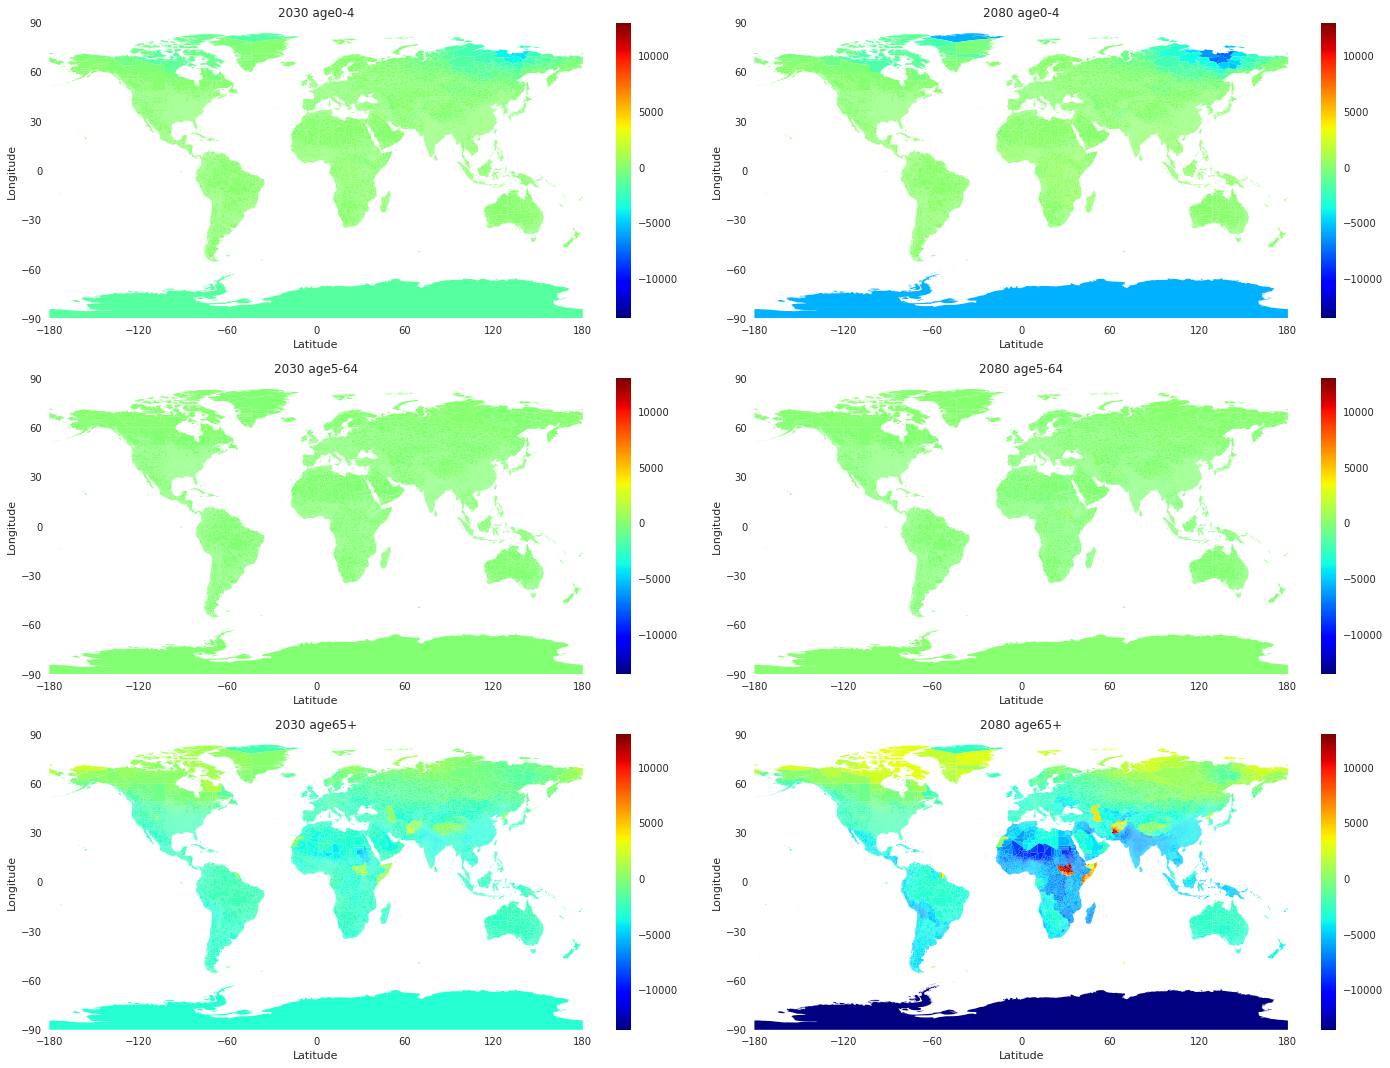

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))


yrange = [
    min(rebased2030.min(), rebased2080.min()),
    max(rebased2030.max(), rebased2080.max())]

formatting = dict(clim=yrange, edgecolors='none', facecolor='white', linewidth=0)

for i, out in enumerate(rebased2030.outcome.values):
    
    visualize.plot_by_hierid(rebased2030.sel(outcome=out), ax=axes[i, 0], **formatting)
    axes[i, 0].set_title('2030 {}'.format(out))
    axes[i, 0].set_facecolor('white')
    
    visualize.plot_by_hierid(rebased2080.sel(outcome=out), ax=axes[i, 1], **formatting)
    axes[i, 1].set_title('2080 {}'.format(out))
    axes[i, 1].set_facecolor('white')

plt.tight_layout()

soooooo... my rationalization for this is that we're actually seeing the benefits of income increasing! the regions with the fastest economic growth are seeing massive declines in mortality. This means we're observing the combined effect of climate change and economic growth, so we really need our no climate change counterfactual!

# Constructing the no climate change counterfactual

we'll use 1981 weather as our no-climate change proxy

In [46]:
metadata = {
    'rcp': 'rcp85',
    'model': 'ACCESS1-0',
    'ssp': 'SSP5',
    'econmodel': 'high'}

w1981, c1981 = mortality_run_setup(year=1981, **metadata)

ncccovars2000 = impact.construct_covars(**{
        'loggdppc': c2000.sel(covarnames='loggdppc'), 
        'climtas': c1981.sel(covarnames='climtas')})

ncccovars2030 = impact.construct_covars(**{
        'loggdppc': c2030.sel(covarnames='loggdppc'), 
        'climtas': c1981.sel(covarnames='climtas')})

ncccovars2080 = impact.construct_covars(**{
        'loggdppc': c2080.sel(covarnames='loggdppc'),
        'climtas': c1981.sel(covarnames='climtas')})

nccbetas2000 = (gm*ncccovars2000).sum(dim='covarnames')
nccbetas2030 = (gm*ncccovars2030).sum(dim='covarnames')
nccbetas2080 = (gm*ncccovars2080).sum(dim='covarnames')

nccmstar2000 = (nccbetas2000*tstar).sum(dim='prednames')
nccmstar2030 = (nccbetas2030*tstar).sum(dim='prednames')
nccmstar2080 = (nccbetas2080*tstar).sum(dim='prednames')

In [47]:
ncc2000 = xr.ufuncs.maximum((nccbetas2000*w1981).sum(dim='prednames'), nccmstar2000).sum(dim='time')
ncc2030 = xr.ufuncs.maximum((nccbetas2030*w1981).sum(dim='prednames'), nccmstar2030).sum(dim='time')
ncc2080 = xr.ufuncs.maximum((nccbetas2080*w1981).sum(dim='prednames'), nccmstar2080).sum(dim='time')

In [48]:
nccrb2030 = ncc2030 - ncc2000
nccrb2080 = ncc2080 - ncc2000

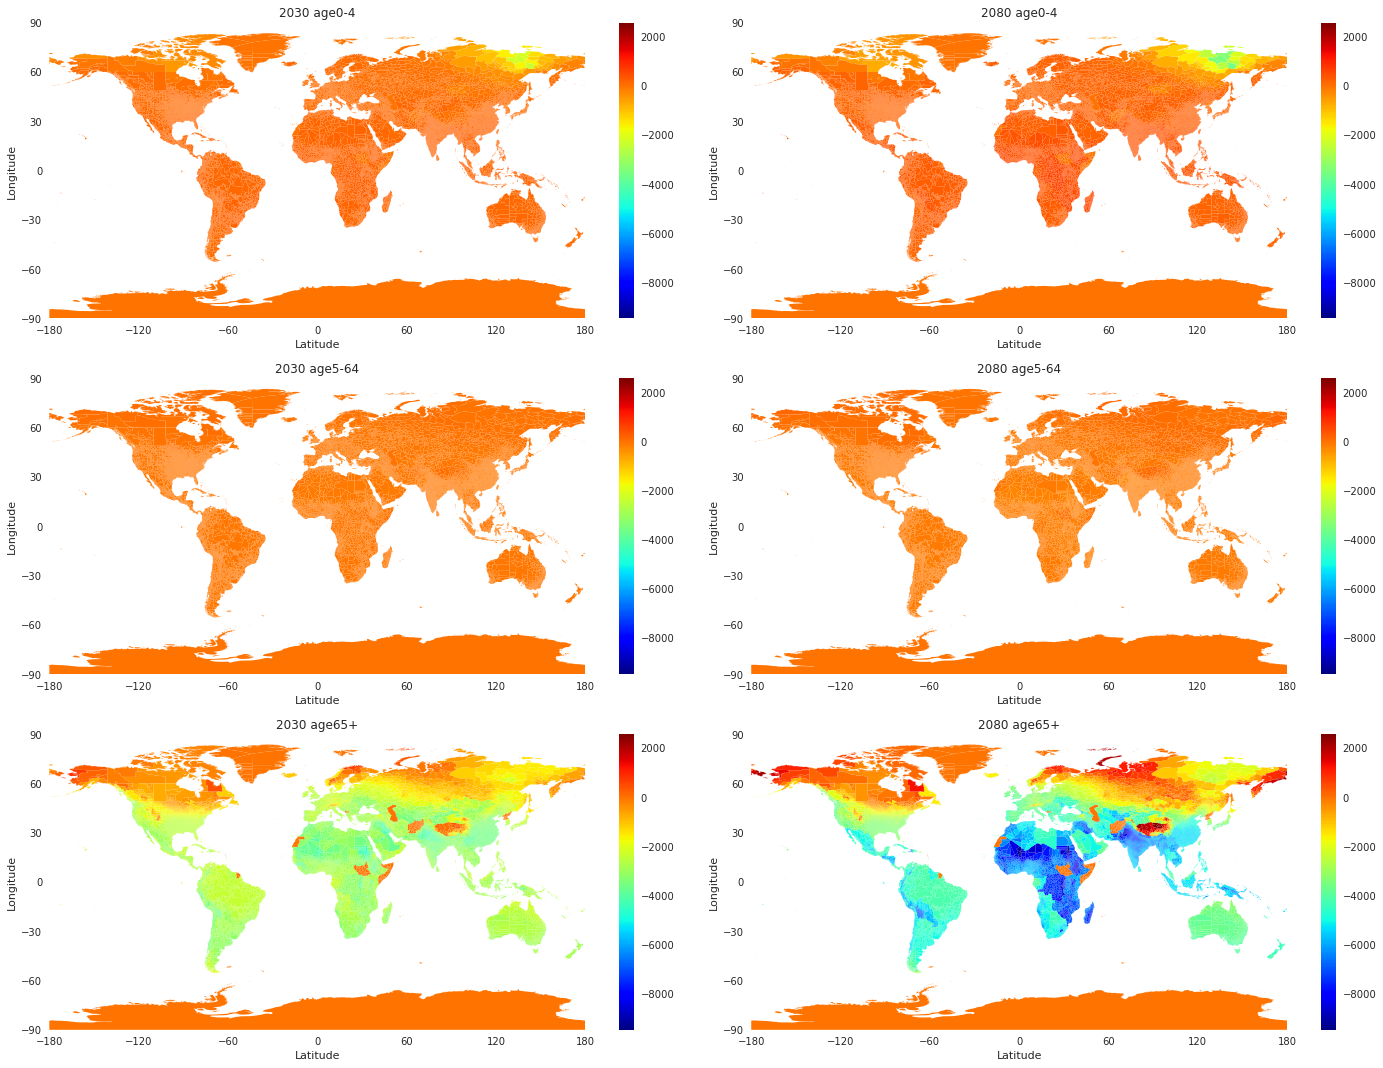

In [49]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))


yrange = [
    min(nccrb2030.min(), nccrb2080.min()),
    max(nccrb2030.max(), nccrb2080.max())]

formatting = dict(clim=yrange, edgecolors='none', facecolor='white', linewidth=0)

for i, out in enumerate(nccrb2030.outcome.values):
    
    visualize.plot_by_hierid(nccrb2030.sel(outcome=out), ax=axes[i, 0], **formatting)
    axes[i, 0].set_title('2030 {}'.format(out))
    axes[i, 0].set_facecolor('white')
    
    visualize.plot_by_hierid(nccrb2080.sel(outcome=out), ax=axes[i, 1], **formatting)
    axes[i, 1].set_title('2080 {}'.format(out))
    axes[i, 1].set_facecolor('white')

plt.tight_layout()

# So, $\left(I-I^B\right)-\left(I^{NCC}-I^B\right)$ is...

In [50]:
final2030 = rebased2030 - nccrb2030
final2080 = rebased2080 - nccrb2080

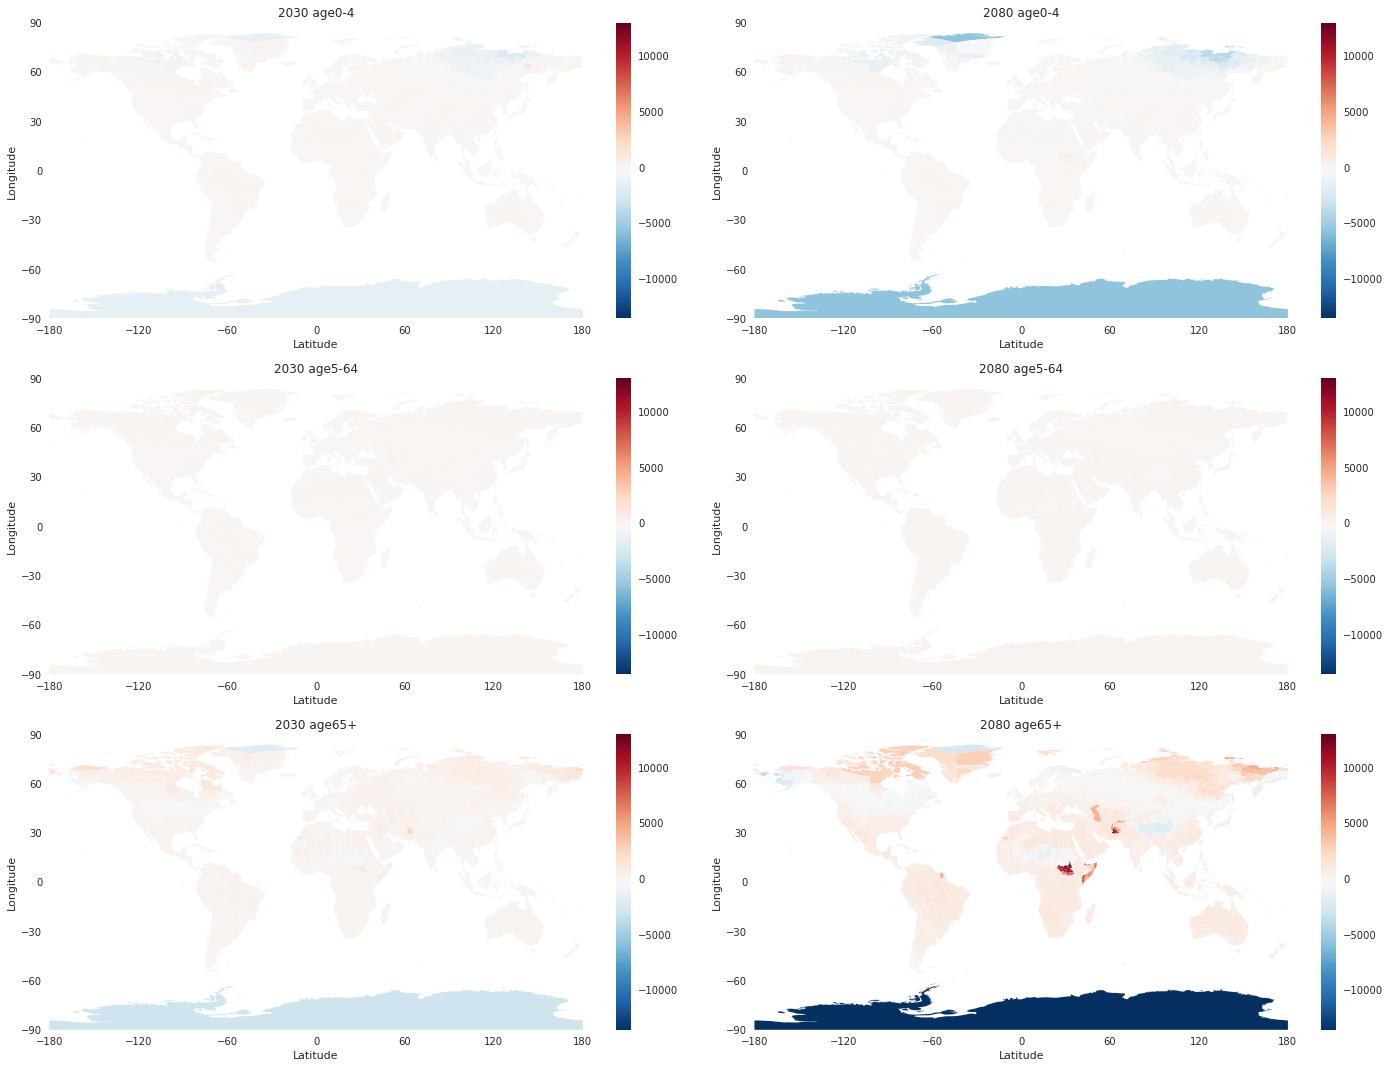

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))


yrange = [
    min(final2030.min(), final2080.min()),
    max(final2030.max(), final2080.max())]

formatting = dict(clim=yrange, edgecolors='none', facecolor='white', linewidth=0, cmap='RdBu_r')

for i, out in enumerate(final2030.outcome.values):
    
    visualize.plot_by_hierid(final2030.sel(outcome=out), ax=axes[i, 0], **formatting)
    axes[i, 0].set_title('2030 {}'.format(out))
    axes[i, 0].set_facecolor('white')
    
    visualize.plot_by_hierid(final2080.sel(outcome=out), ax=axes[i, 1], **formatting)
    axes[i, 1].set_title('2080 {}'.format(out))
    axes[i, 1].set_facecolor('white')

plt.tight_layout()

woot? I'm going to impose a clim.

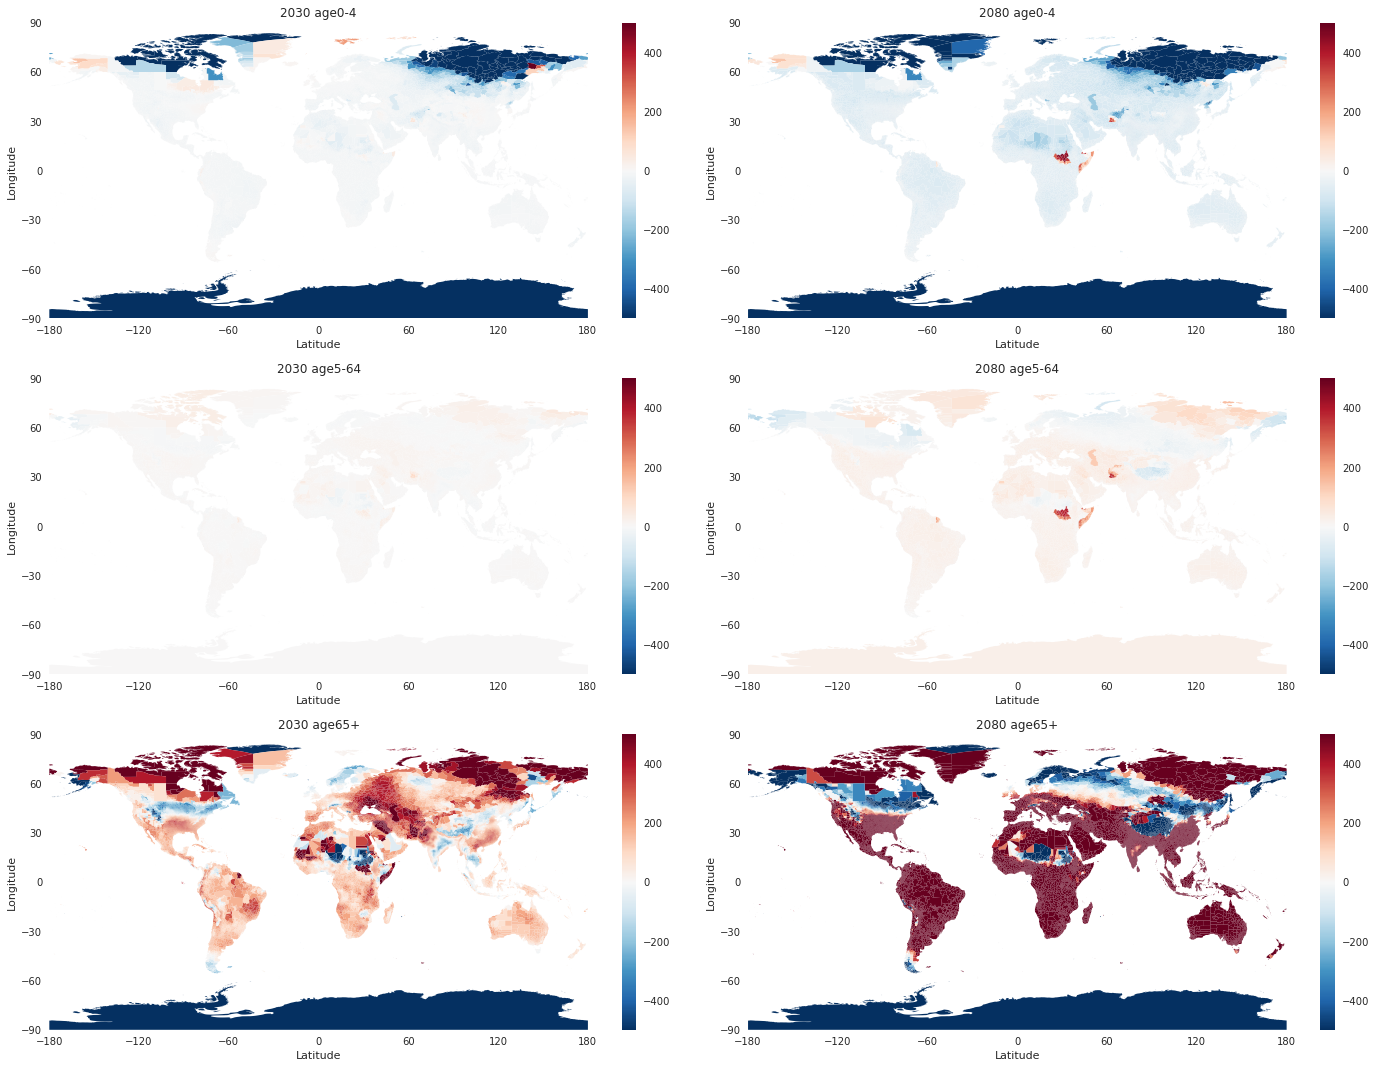

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

yrange = [-500, 500]

formatting = dict(clim=yrange, edgecolors='none', facecolor='white', linewidth=0)

for i, out in enumerate(final2030.outcome.values):
    
    visualize.plot_by_hierid(final2030.sel(outcome=out), ax=axes[i, 0], cmap='RdBu_r', **formatting)
    axes[i, 0].set_title('2030 {}'.format(out))
    axes[i, 0].set_facecolor('white')
    
    visualize.plot_by_hierid(final2080.sel(outcome=out), ax=axes[i, 1], cmap='RdBu_r', **formatting)
    axes[i, 1].set_title('2080 {}'.format(out))
    axes[i, 1].set_facecolor('white')

plt.tight_layout()

huh